# CHAPTER 4 word2vec 속도 개선

3 장에서 구현한 CBOW 모델  
  
<img src='./img/4/cbow_1.png' width=500>  
  
단어 2개를 맥락으로 사용해, 이를 바탕으로 하나의 단어(타깃)을 추측함  
이 때, 입력 측 가중치($W_{in}$)와의 행렬 곱으로 은닉층이 계산되고,  
다시 출력 측 가중치($W_{out}$)와의 행렬 곱으로 각 단어의 점수를 구함  
이 점수에 소프트맥스 함수를 적용해 각 단어의 출현 확률을 얻고,  
확률과 정답 레이블을 교차 엔트로피 오차에 적용하여 손실을 구함  
  
이는 거대한 말뭉치를 다루게 되면 다음 두 계산이 병목됨  
  
- 입력층의 원핫 표현과 가중치 행렬 $W_{in}$의 곱 계산  
  
    단어를 원핫 표현으로 다루기 때문에 어휘 수가 많아지면 웟핫 표현의 벡터 크기도 커짐  
    ex) 어휘가 100만 개라면 그 원핫 표현 하나만 해도 원소 수가 100만개인 벡터가 됨  
      
    그리고 이 원핫 벡터와 가중치 행렬 $W_{out}$을 곱해야 하는데, 이것만으로 계산 자원을 상당히 사용함  
      
    $\rightarrow$ __Embedding 계층을 도입__하는 것으로 개선  
  
  
- 은닉층과 가중치 행렬 $W_{out}$의 곱 및 Softmax 계층의 계산  
  
    은닉층과 가중치 행렬 $W_{out}$의 곱과 softmax 계층에서 다루는 어휘가 많아짐에 따라 계산량이 증가  
      
    $\rightarrow$ __네거티브 샘플링이라는 새로운 함수를 도입__하여 개선  
  

## 4.1 word2vec 개선 ①

### 4.1.1 Embedding 계층

<img src='./img/4/cbow_7.png' width=500>  
  
기존에 구현한 word2vec은 단어를 원핫 표현으로 바꾸고 그 것을 MatMul 계층에 입력하여 가중치 행렬을 곱했음  
하지만 결과적으로 수행하는 일은 단지 행렬의 특정 행을 추출하는 것 뿐임  
  
따라서 입력 측 MatMul 계층을 가중치 매개변수로부터 '단어 ID에 해당하는 행(벡터)'을 추출하는 계층인 Embedding 계층으로 대체  
이로써 메모리 사용량을 줄이고 쓸데없는 계산도 생략할 수 있음  
Embedding 계층은 단어 임베딩(분산 표현)을 저장하게 됨  
  
< 참고 >  
자연어 처리 분야에서 단어의 밀집벡터 표현을 단어 임베딩 혹은 분산 표현(distributed representation)이라고 함
- 통계 기반 기법으로 얻은 단어 벡터 : distributional representation
- 신경망을 사용한 추론 기반 기법으로 얻은 단어 벡터 : distributed representation

### 4.1.2 Embedding 계층 구현

<img src='./img/4/cbow_2.png' width=500>  
  
Embedding 계층의 순전파는 가중치 W의 특정 행을 추출  
따라서 역전파에서는 앞 층(출력 측 층)으로부터 전해진 기울기를 다음 층(입력 측 층)으로 그대로 흘려줌  
다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행(idx번째 행)에 설정

In [1]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout) # np.add.at(A, idx, B)는 B를 A의 idx번째 행에 더해줌  

## 4.2 word2vec 개선 ②

### 4.2.1 은닉층 이후 계산의 문제점

은닉층 이후에서 계산이 오래 걸리는 곳  
- 은닉층의 뉴런과 가중치 행렬($W_{out}$)의 곱  
- Softmax 계층의 계산  

### 4.2.2 다중 분류에서 이진 분류로

'다중 분류(multi-class classification)' 혹은 다중 클래스 분류를 '이진 분류(binary classification)'으로 변환
    
<img src='./img/4/cbow_3.png' width=500>  
  
ex)  
질문 : 맥락이 'you', 'goodbye'일 때, 타깃 단어는 'say'입니까?  
답 : Yes/No(이진분류)  

이렇게 이진분류로 바꾸게되면 출력층에는 뉴런을 하나만 준비하면 됨  
출력층의 뉴런은 'say'의 점수를 출력함  
  


<img src='./img/4/cbow_4.png' width=500>  
  
출력 측의 가중치 $(W_{out})$에는 각 단어 ID의 단어 벡터가 각각의 열로 저장되어 있음  
은닉층과 출력 측의 가중치 행렬의 내적은 'say'에 해당하는 열(단어 벡터)만을 추출하고,  
그 추출된 벡터와 은닉층 뉴런과의 내적을 계산  
이렇게 구한 값이 최종 점수가 되고,  
시그모이드 함수를 이용해 그 점수를 확률로 변환  

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

이진 분류 문제를 신경망으로 풀 때는 보통  
점수에 시그모이드 함수를 적용하여 확률로 변환하고,  
손실 함수로는 '교차 엔트로피 오차'를 사용함  

__시그모이드 함수__  
  
<img src='./img/4/cbow_5.png' width=500>  
  
$y=\frac{1}{1+exp(-x)}$  
  
그래프는 S자 곡선 형태이며, 입력 값(x)은 0에서 1 사이의 실수로 변환됨  
시그모이드 함수의 출력(y)는 '확률'로 해석할 수 있음  
  
__시그모이드 함수의 순전파__  
  
<img src='./img/4/sigmoid_1.png' width=500>  
  
__시그모이드 함수의 역전파__  
  
- 1단계  
  
<img src='./img/4/sigmoid_2.png' width=500>  
  
'/'노드는 $y=\frac{1}{x}$를 뜻하며 미분하면 다음과 같음  
  
$\frac{\partial{y}}{\partial{x}}=-\frac{1}{x^2}=-(\frac{1}{x})^2=-y^2$  
  
따라서 상류의 기울기에 $-y^2$(순전파 출력의 제곱에 마이너스를 붙인 값)을 곱하여 하류로 보냄
  
- 2단계  
  
<img src='./img/4/sigmoid_3.png' width=500>  
  
'+'노드는 상류의 값을 그대로 하류로 보냄  
  
- 3단계  
  
<img src='./img/4/sigmoid_4.png' width=500>  
  
'exp'노드는 $y=exp(x)$를 뜻하며 미분하면 다음과 같음  
  
$\frac{\partial{y}}{\partial{x}}=exp(x)$  
  
상류의 기울기에 순전파 시의 출력(이 예에서는 $exp(-x)$를 곱하여 하류로 보냄  
  
- 4단계  
  
<img src='./img/4/sigmoid_5.png' width=500>  
  
'$\times$'노드는 순전파 시의 입력을 서로 바꾼 값을 곱함  
여기서는 -1을 곱함  
  
이렇게 구해진 값을 정리하면,  
  
$\frac{\partial{L}}{\partial{y}}y^2exp(-x)=\frac{\partial{L}}{\partial{y}}\frac{1}{(1+exp(-x))^2}exp(-x)\\
=\frac{\partial{L}}{\partial{y}}\frac{1}{1+exp(-x)}\frac{exp(-x)}{1+exp(-x)}\\
=\frac{\partial{L}}{\partial{y}}y(1-y)$  
  
위와 같이 시그모이드 함수의 역전파는 순전파 시의 출력만으로 계산할 수 있음
  
  
__교차 엔트로피 오차__  
  
$L=-\sum_kt_klogy_k$  
  
$L=-(tlogy+(1-t)log(1-y))$  
  
정답 레이블 값은 0 혹은 1이므로,  
- t가 1이면 $-logy$ 출력
- t가 0이면 $-log(1-y)$ 출력  
  
------
  
<img src='./img/4/cbow_6.png' width=300>  
  
역전파의 값이 유도되는 과정은 다음과 같음  
  
$\frac{\partial{L}}{\partial{x}}=\frac{\partial{L}}{\partial{y}}\frac{\partial{y}}{\partial{x}}$  
  
$\frac{\partial{L}}{\partial{y}}=-\frac{t}{y}+\frac{1-t}{1-y}=\frac{y-t}{y(1-y)}$  
  
$\frac{\partial{y}}{\partial{x}}=y(1-y)$  
  
따라서, $\frac{\partial{L}}{\partial{x}}=y-t$가 됨
  
여기서 y는 신경망이 출력한 확률이고, t는 정답 레이블로  
$y-t$는 정확히 그 두 값의 차이가 됨  
정답 레이블이 1이라면, y가 1에 가까워질수록 오차가 줄어든다는 뜻  
  
오차가 앞 계층으로 흘러가므로, 오차가 크면 '크게' 학습하고, 오차가 작으면 '작게' 학습  
  
< 참고 >  
  
- '시그모이드 함수' & '교차 엔트로피 오차'
- '소프트맥스 함수' & '교차 엔트로피 오차'
- '항등 함수' & '2 제곱 오차'  
세 조합 모두 역전파 시에는 y-t 값이 전파됨

### 4.2.4 다중 분류에서 이진 분류로 (구현)

<img src='./img/4/cbow_8.png' width=500>  
  
은닉층 뉴런 __h__와 출력 측의 가중치 $W_{out}$에서 단어 'say'에 해당하는 단어 벡터와의 내적을 계산함  
그리고 그 출력을 Sigmoid with Loss 계층에 입력해 최종 손실을 얻음  
  
<img src='./img/4/cbow_9.png' width=500>  
  
위의 그림과 같이  
Embedding 계층과 'dot 연산(내적)'의 처리를 합친 Embedding Dot 계층으로 구현  


In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1) # 내적계산(원소별 곱)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

여기서, cache는 순전파 시의 계산 결과를 잠시 유지하기 위한 변수로 사용  
forward 메서드 인수 중 idx는 단어 ID의 '배열'  
(미니배치 처리'를 가정하여 배열로 받음)

### 4.2.5 네거티브 샘플링

현재까지는 신경망에서 긍정적 예에 대해서만 학습하는 것을 다뤘음  
하지만 긍정적 예에 대해서는 Sigmoid 계층의 출력을 1에 가깝게 만들고,  
부정적인 예(답이 아닌 단어)에 대해서는 Sigmoid 계층의 출력을 0에 가깝게 만드는 가중치를 만들 수 있어야 함  
  
그렇다고 모든 부정적 예를 대상으로 이진 분류를 학습시키면 어휘 수가 늘어난 경우 감당할 수 없기 때문에,  
근사적인 해법으로 적은 수의 부정적 예를 샘플링하여 사용함  
이것이 __네거티브 샘플링 기법__  
  
<img src='./img/4/cbow_10.png' width=500>  
  
정리하면,  
네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구한 후,  
그와 동시에 부정적 예를 몇 개 샘플링하여, 그 부정적 예에 대해서도 손실을 구하고  
각각의 데이터(긍정적 예, 샘플링된 부정적 예)의 손실을 더한 값을 최종 손실로 함

### 4.2.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링에서 샘플링하는 방법은 말뭉치의 통계 데이터를 기초로 샘플링함  
  
말뭉치에서 단어별 출현 횟수를 바탕으로 확률분포를 구한 다음,  
그 확률분포에 따라서 샘플링을 수행함  
말뭉치에서 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어는 적게 추출!  

In [3]:
# 확률분포에 따라 샘플링
import numpy as np

words = ['you','say','goodbye','I','hello','.']
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1] # 확률분포
np.random.choice(words, size=3, p=p)

array(['you', 'you', 'you'], dtype='<U7')

word2vec의 네거티브 샘플링에서는 추가로 확률분포에 0.75를 제곱해야 함  
  
$P'(w_i)=\frac{P(w_i)^{0.75}}{\sum_j^nP(w_j)^{0.75}}$  
  
- $P(w_i)$ : i번째 단어의 확률
단순히 원래 확률분포의 각 요소를 '0.75 제곱'을 함  
다만 수정 후에도 확률의 총 합이 1이 되어야 하므로, 분모로는 '수정 후 확률분포의 총합'으로 수정  
  
0.75 제곱을 수행하는 이유는 낮은 확률의 단어가 (조금 더) 쉽게 샘플링되도록 하기 위한 조치이며,  
0.75라는 수치는 이론적인 의미는 없으므로 다른 값으로 설정해도 됨  
  
정리하면, 네거티브 샘플링은 말뭉치에서 단어의 확률분포를 만들고, 다시 0.75를 제곱한 다음, np.random.choice()를 사용해 부정적 예를 샘플링함

- UnigramSampler 클래스  
    인수목록
    * corpus : 단어 ID 목록
    * power : 확률분포에 '제곱'할 값(기본값은 0.75)
    * sample_size : '부정적 예 샘플링'을 수행하는 횟수  
  
- get_negative_sample  
    target 인수로 지정한 단어를 긍적적 예로 해석하고, 그 외의 단어 ID를 샘플링함  
    (즉, 부정적 예를 골라줌)

In [4]:
import numpy as np
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size) # 확률변수
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

#         if not GPU:
        negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

        for i in range(batch_size):
            p = self.word_p.copy()
            target_idx = target[i]
            p[target_idx] = 0
            p /= p.sum()
            negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
#         else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
#             negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
#                                                replace=True, p=self.word_p)

        return negative_sample

In [5]:
corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 3]
 [1 2]
 [3 1]]


### 4.2.7 네거티브 샘플링 구현

- NegativeSamplingLoss 클래스  
    인수목록
    * W : 출력 측 가중치
    * corpus : 말뭉치(단어 ID 리스트)  
    * power : 확률분포에 제곱할 값
    * sample_size : 부정적 예의 샘플링 횟수  
  
인스턴스 변수인 loss_layer와 embed_dot_layers에는 원하는 계층을 리스트로 보관  
이 때 두 리스트에는 sample_size + 1개의 계층을 생성하는데,  
부정적 예를 다루는 계층이 sample_size개만큼이고, 긍정적 예를 다루는 계층이 하나 더 필요하기 때문임  
0번째 계층, 즉 loss_layers[0]과 embed_dot_layers[0]이 긍정적 예를 다루는 계층임  
  
- forward 메서드  
    인수목록  
    * h : 은닉층 뉴런
    * target : 긍정적 예  
  
self.sampler를 이용하여 부정적 예를 샘플링해 negative_sample에 저장 후,  
긍정적 예와 부정적 예 각각의 데이터에 대해 순전파를 수행  
Embedding Dot 계층의 forward에서 점수를 구하고,  
이 점수와 레이블로 Sigmoid with Loss 계층에서 손실들을 구해서 더함  
  
- backward 메서드  
  
은닉층의 뉴런은 순전파 시에 여러개로 복사되었음  
이는 Repeat 노드에 해당됨  
따라서 역전파 때는 여러 개의 기울기 값을 더해줌

In [6]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sampel_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layer = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layer = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)
        
        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
            
        return loss
    
    def backward(self, dout = 1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
            
        return dh

## 4.3 개선판 word2vec 학습

PTB 데이터셋 사용하여 학습 후 분사표현 얻는 예시

### 4.3.1 CBOW 모델 구현

- CBOW 클래스  
  
SimpleCBOW 클래스(개선 전의 구현)에서는 입력 측의 가중치와 출력 측의 가중치의 형상이 달라서 출력 측의 가중치에선 단어 벡터가 열 방향으로 배치되었으나,  
개선한 CBOW 클래스에서는 NegativeSamplingLoss 클래스에서 Embedding 계층을 사용하기 때문에 입력 측 가중치와 출력 측 가중치가 같은 형상으로, 단어 벡터가 행 방향에 배치됨  
  
- forward 메서드  
    * 인수 contexts, target은 맥락과 타깃의 __단어 ID__  
        (개선 전의 구현에서는 원핫 벡터로 변환해서 사용했었음)  

In [7]:
import numpy as np
from common.layers import Embedding

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size): # 양 쪽
            layer = Embedding(W_in) # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None        

### 4.3.2 CBOW 모델 학습 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 2[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 3[s] | 손실 3.94
| 에폭 1 |  반복 121 / 9295 | 시간 3[s] | 손실 3.80
| 에폭 1 |  반복 141 / 9295 | 시간 4[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 5[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 5[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 6[s] | 손실 3.25
| 에폭 1 |  반복 221 / 9295 | 시간 6[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 7[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 8[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 8[s] | 손실 2.97
| 에폭 1 |  반복 301 / 9295 | 시간 9[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 10[s] | 손실 2.86
| 에폭 1 |  반복 341 / 9295 | 시간 10[s] | 손실 2.86
| 에폭 1 |  반복 361 / 9295 | 시간 11[s] | 손실 2.80
| 에폭 1 |  반복 381 / 9295 | 시간 11[s] | 손실 2.78
| 에폭 1 |  반복 401 / 9295 | 시간 12[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 13[s] | 손실 2.74
| 에폭 1 |  반복 441 / 9295 | 시간 13[

| 에폭 1 |  반복 3601 / 9295 | 시간 111[s] | 손실 2.39
| 에폭 1 |  반복 3621 / 9295 | 시간 111[s] | 손실 2.40
| 에폭 1 |  반복 3641 / 9295 | 시간 112[s] | 손실 2.43
| 에폭 1 |  반복 3661 / 9295 | 시간 112[s] | 손실 2.39
| 에폭 1 |  반복 3681 / 9295 | 시간 113[s] | 손실 2.38
| 에폭 1 |  반복 3701 / 9295 | 시간 114[s] | 손실 2.43
| 에폭 1 |  반복 3721 / 9295 | 시간 114[s] | 손실 2.38
| 에폭 1 |  반복 3741 / 9295 | 시간 115[s] | 손실 2.39
| 에폭 1 |  반복 3761 / 9295 | 시간 116[s] | 손실 2.41
| 에폭 1 |  반복 3781 / 9295 | 시간 116[s] | 손실 2.41
| 에폭 1 |  반복 3801 / 9295 | 시간 117[s] | 손실 2.42
| 에폭 1 |  반복 3821 / 9295 | 시간 117[s] | 손실 2.40
| 에폭 1 |  반복 3841 / 9295 | 시간 118[s] | 손실 2.41
| 에폭 1 |  반복 3861 / 9295 | 시간 119[s] | 손실 2.40
| 에폭 1 |  반복 3881 / 9295 | 시간 119[s] | 손실 2.41
| 에폭 1 |  반복 3901 / 9295 | 시간 120[s] | 손실 2.42
| 에폭 1 |  반복 3921 / 9295 | 시간 120[s] | 손실 2.39
| 에폭 1 |  반복 3941 / 9295 | 시간 121[s] | 손실 2.39
| 에폭 1 |  반복 3961 / 9295 | 시간 122[s] | 손실 2.38
| 에폭 1 |  반복 3981 / 9295 | 시간 122[s] | 손실 2.43
| 에폭 1 |  반복 4001 / 9295 | 시간 123[s] | 손실 2.41
| 에폭 1 |  반복 

| 에폭 1 |  반복 7101 / 9295 | 시간 220[s] | 손실 2.25
| 에폭 1 |  반복 7121 / 9295 | 시간 221[s] | 손실 2.28
| 에폭 1 |  반복 7141 / 9295 | 시간 221[s] | 손실 2.29
| 에폭 1 |  반복 7161 / 9295 | 시간 222[s] | 손실 2.30
| 에폭 1 |  반복 7181 / 9295 | 시간 223[s] | 손실 2.26
| 에폭 1 |  반복 7201 / 9295 | 시간 223[s] | 손실 2.26
| 에폭 1 |  반복 7221 / 9295 | 시간 224[s] | 손실 2.28
| 에폭 1 |  반복 7241 / 9295 | 시간 224[s] | 손실 2.29
| 에폭 1 |  반복 7261 / 9295 | 시간 225[s] | 손실 2.29
| 에폭 1 |  반복 7281 / 9295 | 시간 226[s] | 손실 2.24
| 에폭 1 |  반복 7301 / 9295 | 시간 226[s] | 손실 2.27
| 에폭 1 |  반복 7321 / 9295 | 시간 227[s] | 손실 2.29
| 에폭 1 |  반복 7341 / 9295 | 시간 228[s] | 손실 2.28
| 에폭 1 |  반복 7361 / 9295 | 시간 228[s] | 손실 2.29
| 에폭 1 |  반복 7381 / 9295 | 시간 229[s] | 손실 2.27
| 에폭 1 |  반복 7401 / 9295 | 시간 229[s] | 손실 2.29
| 에폭 1 |  반복 7421 / 9295 | 시간 230[s] | 손실 2.29
| 에폭 1 |  반복 7441 / 9295 | 시간 231[s] | 손실 2.30
| 에폭 1 |  반복 7461 / 9295 | 시간 231[s] | 손실 2.27
| 에폭 1 |  반복 7481 / 9295 | 시간 232[s] | 손실 2.24
| 에폭 1 |  반복 7501 / 9295 | 시간 233[s] | 손실 2.28
| 에폭 1 |  반복 

| 에폭 2 |  반복 1321 / 9295 | 시간 330[s] | 손실 2.16
| 에폭 2 |  반복 1341 / 9295 | 시간 331[s] | 손실 2.18
| 에폭 2 |  반복 1361 / 9295 | 시간 331[s] | 손실 2.17
| 에폭 2 |  반복 1381 / 9295 | 시간 332[s] | 손실 2.14
| 에폭 2 |  반복 1401 / 9295 | 시간 333[s] | 손실 2.16
| 에폭 2 |  반복 1421 / 9295 | 시간 333[s] | 손실 2.15
| 에폭 2 |  반복 1441 / 9295 | 시간 334[s] | 손실 2.13
| 에폭 2 |  반복 1461 / 9295 | 시간 334[s] | 손실 2.16
| 에폭 2 |  반복 1481 / 9295 | 시간 335[s] | 손실 2.13
| 에폭 2 |  반복 1501 / 9295 | 시간 336[s] | 손실 2.15
| 에폭 2 |  반복 1521 / 9295 | 시간 336[s] | 손실 2.15
| 에폭 2 |  반복 1541 / 9295 | 시간 337[s] | 손실 2.12
| 에폭 2 |  반복 1561 / 9295 | 시간 338[s] | 손실 2.12
| 에폭 2 |  반복 1581 / 9295 | 시간 338[s] | 손실 2.10
| 에폭 2 |  반복 1601 / 9295 | 시간 339[s] | 손실 2.12
| 에폭 2 |  반복 1621 / 9295 | 시간 339[s] | 손실 2.10
| 에폭 2 |  반복 1641 / 9295 | 시간 340[s] | 손실 2.14
| 에폭 2 |  반복 1661 / 9295 | 시간 341[s] | 손실 2.13
| 에폭 2 |  반복 1681 / 9295 | 시간 341[s] | 손실 2.13
| 에폭 2 |  반복 1701 / 9295 | 시간 342[s] | 손실 2.12
| 에폭 2 |  반복 1721 / 9295 | 시간 343[s] | 손실 2.16
| 에폭 2 |  반복 

| 에폭 2 |  반복 4821 / 9295 | 시간 439[s] | 손실 2.05
| 에폭 2 |  반복 4841 / 9295 | 시간 440[s] | 손실 2.08
| 에폭 2 |  반복 4861 / 9295 | 시간 441[s] | 손실 2.08
| 에폭 2 |  반복 4881 / 9295 | 시간 441[s] | 손실 2.08
| 에폭 2 |  반복 4901 / 9295 | 시간 442[s] | 손실 2.08
| 에폭 2 |  반복 4921 / 9295 | 시간 442[s] | 손실 2.10
| 에폭 2 |  반복 4941 / 9295 | 시간 443[s] | 손실 2.05
| 에폭 2 |  반복 4961 / 9295 | 시간 444[s] | 손실 2.11
| 에폭 2 |  반복 4981 / 9295 | 시간 444[s] | 손실 2.06
| 에폭 2 |  반복 5001 / 9295 | 시간 445[s] | 손실 2.05
| 에폭 2 |  반복 5021 / 9295 | 시간 446[s] | 손실 2.08
| 에폭 2 |  반복 5041 / 9295 | 시간 446[s] | 손실 2.09
| 에폭 2 |  반복 5061 / 9295 | 시간 447[s] | 손실 2.08
| 에폭 2 |  반복 5081 / 9295 | 시간 447[s] | 손실 2.06
| 에폭 2 |  반복 5101 / 9295 | 시간 448[s] | 손실 2.07
| 에폭 2 |  반복 5121 / 9295 | 시간 449[s] | 손실 2.08
| 에폭 2 |  반복 5141 / 9295 | 시간 449[s] | 손실 2.07
| 에폭 2 |  반복 5161 / 9295 | 시간 450[s] | 손실 2.07
| 에폭 2 |  반복 5181 / 9295 | 시간 451[s] | 손실 2.08
| 에폭 2 |  반복 5201 / 9295 | 시간 451[s] | 손실 2.11
| 에폭 2 |  반복 5221 / 9295 | 시간 452[s] | 손실 2.10
| 에폭 2 |  반복 

| 에폭 2 |  반복 8321 / 9295 | 시간 549[s] | 손실 2.03
| 에폭 2 |  반복 8341 / 9295 | 시간 550[s] | 손실 2.05
| 에폭 2 |  반복 8361 / 9295 | 시간 551[s] | 손실 2.00
| 에폭 2 |  반복 8381 / 9295 | 시간 551[s] | 손실 2.00
| 에폭 2 |  반복 8401 / 9295 | 시간 552[s] | 손실 2.04
| 에폭 2 |  반복 8421 / 9295 | 시간 552[s] | 손실 2.01
| 에폭 2 |  반복 8441 / 9295 | 시간 553[s] | 손실 2.03
| 에폭 2 |  반복 8461 / 9295 | 시간 554[s] | 손실 2.07
| 에폭 2 |  반복 8481 / 9295 | 시간 554[s] | 손실 2.06
| 에폭 2 |  반복 8501 / 9295 | 시간 555[s] | 손실 2.01
| 에폭 2 |  반복 8521 / 9295 | 시간 556[s] | 손실 2.02
| 에폭 2 |  반복 8541 / 9295 | 시간 556[s] | 손실 2.03
| 에폭 2 |  반복 8561 / 9295 | 시간 557[s] | 손실 1.99
| 에폭 2 |  반복 8581 / 9295 | 시간 557[s] | 손실 2.03
| 에폭 2 |  반복 8601 / 9295 | 시간 558[s] | 손실 2.01
| 에폭 2 |  반복 8621 / 9295 | 시간 559[s] | 손실 2.00
| 에폭 2 |  반복 8641 / 9295 | 시간 559[s] | 손실 2.02
| 에폭 2 |  반복 8661 / 9295 | 시간 560[s] | 손실 2.04
| 에폭 2 |  반복 8681 / 9295 | 시간 561[s] | 손실 2.04
| 에폭 2 |  반복 8701 / 9295 | 시간 561[s] | 손실 2.04
| 에폭 2 |  반복 8721 / 9295 | 시간 562[s] | 손실 2.01
| 에폭 2 |  반복 

| 에폭 3 |  반복 2541 / 9295 | 시간 660[s] | 손실 1.94
| 에폭 3 |  반복 2561 / 9295 | 시간 661[s] | 손실 1.93
| 에폭 3 |  반복 2581 / 9295 | 시간 661[s] | 손실 1.96
| 에폭 3 |  반복 2601 / 9295 | 시간 662[s] | 손실 1.95
| 에폭 3 |  반복 2621 / 9295 | 시간 662[s] | 손실 1.93
| 에폭 3 |  반복 2641 / 9295 | 시간 663[s] | 손실 1.93
| 에폭 3 |  반복 2661 / 9295 | 시간 664[s] | 손실 1.93
| 에폭 3 |  반복 2681 / 9295 | 시간 664[s] | 손실 1.97
| 에폭 3 |  반복 2701 / 9295 | 시간 665[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 666[s] | 손실 1.93
| 에폭 3 |  반복 2741 / 9295 | 시간 666[s] | 손실 1.92
| 에폭 3 |  반복 2761 / 9295 | 시간 667[s] | 손실 1.91
| 에폭 3 |  반복 2781 / 9295 | 시간 667[s] | 손실 1.95
| 에폭 3 |  반복 2801 / 9295 | 시간 668[s] | 손실 1.93
| 에폭 3 |  반복 2821 / 9295 | 시간 669[s] | 손실 1.92
| 에폭 3 |  반복 2841 / 9295 | 시간 669[s] | 손실 1.98
| 에폭 3 |  반복 2861 / 9295 | 시간 670[s] | 손실 1.93
| 에폭 3 |  반복 2881 / 9295 | 시간 671[s] | 손실 1.93
| 에폭 3 |  반복 2901 / 9295 | 시간 671[s] | 손실 1.97
| 에폭 3 |  반복 2921 / 9295 | 시간 672[s] | 손실 1.95
| 에폭 3 |  반복 2941 / 9295 | 시간 672[s] | 손실 1.92
| 에폭 3 |  반복 

| 에폭 3 |  반복 6041 / 9295 | 시간 769[s] | 손실 1.93
| 에폭 3 |  반복 6061 / 9295 | 시간 770[s] | 손실 1.92
| 에폭 3 |  반복 6081 / 9295 | 시간 771[s] | 손실 1.93
| 에폭 3 |  반복 6101 / 9295 | 시간 771[s] | 손실 1.91
| 에폭 3 |  반복 6121 / 9295 | 시간 772[s] | 손실 1.87
| 에폭 3 |  반복 6141 / 9295 | 시간 773[s] | 손실 1.86
| 에폭 3 |  반복 6161 / 9295 | 시간 773[s] | 손실 1.90
| 에폭 3 |  반복 6181 / 9295 | 시간 774[s] | 손실 1.93
| 에폭 3 |  반복 6201 / 9295 | 시간 774[s] | 손실 1.91
| 에폭 3 |  반복 6221 / 9295 | 시간 775[s] | 손실 1.90
| 에폭 3 |  반복 6241 / 9295 | 시간 776[s] | 손실 1.96
| 에폭 3 |  반복 6261 / 9295 | 시간 776[s] | 손실 1.95
| 에폭 3 |  반복 6281 / 9295 | 시간 777[s] | 손실 1.92
| 에폭 3 |  반복 6301 / 9295 | 시간 778[s] | 손실 1.91
| 에폭 3 |  반복 6321 / 9295 | 시간 778[s] | 손실 1.89
| 에폭 3 |  반복 6341 / 9295 | 시간 779[s] | 손실 1.91
| 에폭 3 |  반복 6361 / 9295 | 시간 779[s] | 손실 1.91
| 에폭 3 |  반복 6381 / 9295 | 시간 780[s] | 손실 1.88
| 에폭 3 |  반복 6401 / 9295 | 시간 781[s] | 손실 1.91
| 에폭 3 |  반복 6421 / 9295 | 시간 781[s] | 손실 1.89
| 에폭 3 |  반복 6441 / 9295 | 시간 782[s] | 손실 1.95
| 에폭 3 |  반복 

| 에폭 4 |  반복 241 / 9295 | 시간 879[s] | 손실 1.82
| 에폭 4 |  반복 261 / 9295 | 시간 879[s] | 손실 1.81
| 에폭 4 |  반복 281 / 9295 | 시간 880[s] | 손실 1.83
| 에폭 4 |  반복 301 / 9295 | 시간 881[s] | 손실 1.84
| 에폭 4 |  반복 321 / 9295 | 시간 881[s] | 손실 1.85
| 에폭 4 |  반복 341 / 9295 | 시간 882[s] | 손실 1.82
| 에폭 4 |  반복 361 / 9295 | 시간 882[s] | 손실 1.79
| 에폭 4 |  반복 381 / 9295 | 시간 883[s] | 손실 1.83
| 에폭 4 |  반복 401 / 9295 | 시간 884[s] | 손실 1.80
| 에폭 4 |  반복 421 / 9295 | 시간 884[s] | 손실 1.83
| 에폭 4 |  반복 441 / 9295 | 시간 885[s] | 손실 1.80
| 에폭 4 |  반복 461 / 9295 | 시간 885[s] | 손실 1.82
| 에폭 4 |  반복 481 / 9295 | 시간 886[s] | 손실 1.79
| 에폭 4 |  반복 501 / 9295 | 시간 887[s] | 손실 1.85
| 에폭 4 |  반복 521 / 9295 | 시간 887[s] | 손실 1.80
| 에폭 4 |  반복 541 / 9295 | 시간 888[s] | 손실 1.82
| 에폭 4 |  반복 561 / 9295 | 시간 889[s] | 손실 1.80
| 에폭 4 |  반복 581 / 9295 | 시간 889[s] | 손실 1.83
| 에폭 4 |  반복 601 / 9295 | 시간 890[s] | 손실 1.83
| 에폭 4 |  반복 621 / 9295 | 시간 890[s] | 손실 1.83
| 에폭 4 |  반복 641 / 9295 | 시간 891[s] | 손실 1.80
| 에폭 4 |  반복 661 / 9295 | 시간 892[s

| 에폭 4 |  반복 3761 / 9295 | 시간 989[s] | 손실 1.82
| 에폭 4 |  반복 3781 / 9295 | 시간 990[s] | 손실 1.87
| 에폭 4 |  반복 3801 / 9295 | 시간 991[s] | 손실 1.82
| 에폭 4 |  반복 3821 / 9295 | 시간 991[s] | 손실 1.82
| 에폭 4 |  반복 3841 / 9295 | 시간 992[s] | 손실 1.82
| 에폭 4 |  반복 3861 / 9295 | 시간 993[s] | 손실 1.80
| 에폭 4 |  반복 3881 / 9295 | 시간 993[s] | 손실 1.87
| 에폭 4 |  반복 3901 / 9295 | 시간 994[s] | 손실 1.79
| 에폭 4 |  반복 3921 / 9295 | 시간 994[s] | 손실 1.78
| 에폭 4 |  반복 3941 / 9295 | 시간 995[s] | 손실 1.77
| 에폭 4 |  반복 3961 / 9295 | 시간 996[s] | 손실 1.82
| 에폭 4 |  반복 3981 / 9295 | 시간 996[s] | 손실 1.82
| 에폭 4 |  반복 4001 / 9295 | 시간 997[s] | 손실 1.85
| 에폭 4 |  반복 4021 / 9295 | 시간 998[s] | 손실 1.79
| 에폭 4 |  반복 4041 / 9295 | 시간 998[s] | 손실 1.84
| 에폭 4 |  반복 4061 / 9295 | 시간 999[s] | 손실 1.80
| 에폭 4 |  반복 4081 / 9295 | 시간 999[s] | 손실 1.79
| 에폭 4 |  반복 4101 / 9295 | 시간 1000[s] | 손실 1.82
| 에폭 4 |  반복 4121 / 9295 | 시간 1001[s] | 손실 1.84
| 에폭 4 |  반복 4141 / 9295 | 시간 1001[s] | 손실 1.80
| 에폭 4 |  반복 4161 / 9295 | 시간 1002[s] | 손실 1.79
| 에폭 4 | 

| 에폭 4 |  반복 7201 / 9295 | 시간 1097[s] | 손실 1.81
| 에폭 4 |  반복 7221 / 9295 | 시간 1098[s] | 손실 1.82
| 에폭 4 |  반복 7241 / 9295 | 시간 1099[s] | 손실 1.82
| 에폭 4 |  반복 7261 / 9295 | 시간 1099[s] | 손실 1.78
| 에폭 4 |  반복 7281 / 9295 | 시간 1100[s] | 손실 1.81
| 에폭 4 |  반복 7301 / 9295 | 시간 1100[s] | 손실 1.81
| 에폭 4 |  반복 7321 / 9295 | 시간 1101[s] | 손실 1.81
| 에폭 4 |  반복 7341 / 9295 | 시간 1102[s] | 손실 1.78
| 에폭 4 |  반복 7361 / 9295 | 시간 1102[s] | 손실 1.80
| 에폭 4 |  반복 7381 / 9295 | 시간 1103[s] | 손실 1.79
| 에폭 4 |  반복 7401 / 9295 | 시간 1104[s] | 손실 1.79
| 에폭 4 |  반복 7421 / 9295 | 시간 1104[s] | 손실 1.84
| 에폭 4 |  반복 7441 / 9295 | 시간 1105[s] | 손실 1.84
| 에폭 4 |  반복 7461 / 9295 | 시간 1105[s] | 손실 1.81
| 에폭 4 |  반복 7481 / 9295 | 시간 1106[s] | 손실 1.85
| 에폭 4 |  반복 7501 / 9295 | 시간 1107[s] | 손실 1.78
| 에폭 4 |  반복 7521 / 9295 | 시간 1107[s] | 손실 1.82
| 에폭 4 |  반복 7541 / 9295 | 시간 1108[s] | 손실 1.79
| 에폭 4 |  반복 7561 / 9295 | 시간 1109[s] | 손실 1.79
| 에폭 4 |  반복 7581 / 9295 | 시간 1109[s] | 손실 1.78
| 에폭 4 |  반복 7601 / 9295 | 시간 1110[s] | 

| 에폭 5 |  반복 1341 / 9295 | 시간 1205[s] | 손실 1.75
| 에폭 5 |  반복 1361 / 9295 | 시간 1205[s] | 손실 1.72
| 에폭 5 |  반복 1381 / 9295 | 시간 1206[s] | 손실 1.75
| 에폭 5 |  반복 1401 / 9295 | 시간 1206[s] | 손실 1.72
| 에폭 5 |  반복 1421 / 9295 | 시간 1207[s] | 손실 1.74
| 에폭 5 |  반복 1441 / 9295 | 시간 1208[s] | 손실 1.72
| 에폭 5 |  반복 1461 / 9295 | 시간 1208[s] | 손실 1.74
| 에폭 5 |  반복 1481 / 9295 | 시간 1209[s] | 손실 1.74
| 에폭 5 |  반복 1501 / 9295 | 시간 1209[s] | 손실 1.71
| 에폭 5 |  반복 1521 / 9295 | 시간 1210[s] | 손실 1.72
| 에폭 5 |  반복 1541 / 9295 | 시간 1211[s] | 손실 1.72
| 에폭 5 |  반복 1561 / 9295 | 시간 1211[s] | 손실 1.68
| 에폭 5 |  반복 1581 / 9295 | 시간 1212[s] | 손실 1.74
| 에폭 5 |  반복 1601 / 9295 | 시간 1213[s] | 손실 1.72
| 에폭 5 |  반복 1621 / 9295 | 시간 1213[s] | 손실 1.74
| 에폭 5 |  반복 1641 / 9295 | 시간 1214[s] | 손실 1.70
| 에폭 5 |  반복 1661 / 9295 | 시간 1214[s] | 손실 1.74
| 에폭 5 |  반복 1681 / 9295 | 시간 1215[s] | 손실 1.74
| 에폭 5 |  반복 1701 / 9295 | 시간 1216[s] | 손실 1.72
| 에폭 5 |  반복 1721 / 9295 | 시간 1216[s] | 손실 1.75
| 에폭 5 |  반복 1741 / 9295 | 시간 1217[s] | 

| 에폭 5 |  반복 4761 / 9295 | 시간 1311[s] | 손실 1.71
| 에폭 5 |  반복 4781 / 9295 | 시간 1311[s] | 손실 1.71
| 에폭 5 |  반복 4801 / 9295 | 시간 1312[s] | 손실 1.73
| 에폭 5 |  반복 4821 / 9295 | 시간 1313[s] | 손실 1.76
| 에폭 5 |  반복 4841 / 9295 | 시간 1313[s] | 손실 1.71
| 에폭 5 |  반복 4861 / 9295 | 시간 1314[s] | 손실 1.73
| 에폭 5 |  반복 4881 / 9295 | 시간 1315[s] | 손실 1.74
| 에폭 5 |  반복 4901 / 9295 | 시간 1315[s] | 손실 1.74
| 에폭 5 |  반복 4921 / 9295 | 시간 1316[s] | 손실 1.73
| 에폭 5 |  반복 4941 / 9295 | 시간 1316[s] | 손실 1.73
| 에폭 5 |  반복 4961 / 9295 | 시간 1317[s] | 손실 1.72
| 에폭 5 |  반복 4981 / 9295 | 시간 1318[s] | 손실 1.70
| 에폭 5 |  반복 5001 / 9295 | 시간 1318[s] | 손실 1.73
| 에폭 5 |  반복 5021 / 9295 | 시간 1319[s] | 손실 1.72
| 에폭 5 |  반복 5041 / 9295 | 시간 1320[s] | 손실 1.71
| 에폭 5 |  반복 5061 / 9295 | 시간 1320[s] | 손실 1.71
| 에폭 5 |  반복 5081 / 9295 | 시간 1321[s] | 손실 1.74
| 에폭 5 |  반복 5101 / 9295 | 시간 1321[s] | 손실 1.71
| 에폭 5 |  반복 5121 / 9295 | 시간 1322[s] | 손실 1.72
| 에폭 5 |  반복 5141 / 9295 | 시간 1323[s] | 손실 1.73
| 에폭 5 |  반복 5161 / 9295 | 시간 1323[s] | 

| 에폭 5 |  반복 8181 / 9295 | 시간 1417[s] | 손실 1.71
| 에폭 5 |  반복 8201 / 9295 | 시간 1418[s] | 손실 1.73
| 에폭 5 |  반복 8221 / 9295 | 시간 1418[s] | 손실 1.71
| 에폭 5 |  반복 8241 / 9295 | 시간 1419[s] | 손실 1.73
| 에폭 5 |  반복 8261 / 9295 | 시간 1420[s] | 손실 1.70
| 에폭 5 |  반복 8281 / 9295 | 시간 1420[s] | 손실 1.72
| 에폭 5 |  반복 8301 / 9295 | 시간 1421[s] | 손실 1.76
| 에폭 5 |  반복 8321 / 9295 | 시간 1422[s] | 손실 1.72
| 에폭 5 |  반복 8341 / 9295 | 시간 1422[s] | 손실 1.76
| 에폭 5 |  반복 8361 / 9295 | 시간 1423[s] | 손실 1.75
| 에폭 5 |  반복 8381 / 9295 | 시간 1423[s] | 손실 1.71
| 에폭 5 |  반복 8401 / 9295 | 시간 1424[s] | 손실 1.70
| 에폭 5 |  반복 8421 / 9295 | 시간 1425[s] | 손실 1.71
| 에폭 5 |  반복 8441 / 9295 | 시간 1425[s] | 손실 1.76
| 에폭 5 |  반복 8461 / 9295 | 시간 1426[s] | 손실 1.74
| 에폭 5 |  반복 8481 / 9295 | 시간 1427[s] | 손실 1.74
| 에폭 5 |  반복 8501 / 9295 | 시간 1427[s] | 손실 1.71
| 에폭 5 |  반복 8521 / 9295 | 시간 1428[s] | 손실 1.75
| 에폭 5 |  반복 8541 / 9295 | 시간 1428[s] | 손실 1.72
| 에폭 5 |  반복 8561 / 9295 | 시간 1429[s] | 손실 1.72
| 에폭 5 |  반복 8581 / 9295 | 시간 1430[s] | 

| 에폭 6 |  반복 2321 / 9295 | 시간 1524[s] | 손실 1.69
| 에폭 6 |  반복 2341 / 9295 | 시간 1525[s] | 손실 1.66
| 에폭 6 |  반복 2361 / 9295 | 시간 1525[s] | 손실 1.67
| 에폭 6 |  반복 2381 / 9295 | 시간 1526[s] | 손실 1.62
| 에폭 6 |  반복 2401 / 9295 | 시간 1527[s] | 손실 1.64
| 에폭 6 |  반복 2421 / 9295 | 시간 1527[s] | 손실 1.64
| 에폭 6 |  반복 2441 / 9295 | 시간 1528[s] | 손실 1.69
| 에폭 6 |  반복 2461 / 9295 | 시간 1528[s] | 손실 1.67
| 에폭 6 |  반복 2481 / 9295 | 시간 1529[s] | 손실 1.65
| 에폭 6 |  반복 2501 / 9295 | 시간 1530[s] | 손실 1.67
| 에폭 6 |  반복 2521 / 9295 | 시간 1530[s] | 손실 1.64
| 에폭 6 |  반복 2541 / 9295 | 시간 1531[s] | 손실 1.67
| 에폭 6 |  반복 2561 / 9295 | 시간 1532[s] | 손실 1.65
| 에폭 6 |  반복 2581 / 9295 | 시간 1532[s] | 손실 1.67
| 에폭 6 |  반복 2601 / 9295 | 시간 1533[s] | 손실 1.61
| 에폭 6 |  반복 2621 / 9295 | 시간 1533[s] | 손실 1.66
| 에폭 6 |  반복 2641 / 9295 | 시간 1534[s] | 손실 1.64
| 에폭 6 |  반복 2661 / 9295 | 시간 1535[s] | 손실 1.66
| 에폭 6 |  반복 2681 / 9295 | 시간 1535[s] | 손실 1.67
| 에폭 6 |  반복 2701 / 9295 | 시간 1536[s] | 손실 1.63
| 에폭 6 |  반복 2721 / 9295 | 시간 1537[s] | 

| 에폭 6 |  반복 5741 / 9295 | 시간 1631[s] | 손실 1.69
| 에폭 6 |  반복 5761 / 9295 | 시간 1631[s] | 손실 1.68
| 에폭 6 |  반복 5781 / 9295 | 시간 1632[s] | 손실 1.66
| 에폭 6 |  반복 5801 / 9295 | 시간 1632[s] | 손실 1.59
| 에폭 6 |  반복 5821 / 9295 | 시간 1633[s] | 손실 1.68
| 에폭 6 |  반복 5841 / 9295 | 시간 1634[s] | 손실 1.64
| 에폭 6 |  반복 5861 / 9295 | 시간 1634[s] | 손실 1.69
| 에폭 6 |  반복 5881 / 9295 | 시간 1635[s] | 손실 1.66
| 에폭 6 |  반복 5901 / 9295 | 시간 1636[s] | 손실 1.65
| 에폭 6 |  반복 5921 / 9295 | 시간 1636[s] | 손실 1.65
| 에폭 6 |  반복 5941 / 9295 | 시간 1637[s] | 손실 1.61
| 에폭 6 |  반복 5961 / 9295 | 시간 1637[s] | 손실 1.64
| 에폭 6 |  반복 5981 / 9295 | 시간 1638[s] | 손실 1.64
| 에폭 6 |  반복 6001 / 9295 | 시간 1639[s] | 손실 1.67
| 에폭 6 |  반복 6021 / 9295 | 시간 1639[s] | 손실 1.66
| 에폭 6 |  반복 6041 / 9295 | 시간 1640[s] | 손실 1.65
| 에폭 6 |  반복 6061 / 9295 | 시간 1640[s] | 손실 1.64
| 에폭 6 |  반복 6081 / 9295 | 시간 1641[s] | 손실 1.63
| 에폭 6 |  반복 6101 / 9295 | 시간 1642[s] | 손실 1.70
| 에폭 6 |  반복 6121 / 9295 | 시간 1642[s] | 손실 1.64
| 에폭 6 |  반복 6141 / 9295 | 시간 1643[s] | 

| 에폭 6 |  반복 9161 / 9295 | 시간 1737[s] | 손실 1.67
| 에폭 6 |  반복 9181 / 9295 | 시간 1738[s] | 손실 1.66
| 에폭 6 |  반복 9201 / 9295 | 시간 1738[s] | 손실 1.63
| 에폭 6 |  반복 9221 / 9295 | 시간 1739[s] | 손실 1.59
| 에폭 6 |  반복 9241 / 9295 | 시간 1739[s] | 손실 1.66
| 에폭 6 |  반복 9261 / 9295 | 시간 1740[s] | 손실 1.65
| 에폭 6 |  반복 9281 / 9295 | 시간 1741[s] | 손실 1.65
| 에폭 7 |  반복 1 / 9295 | 시간 1741[s] | 손실 1.61
| 에폭 7 |  반복 21 / 9295 | 시간 1742[s] | 손실 1.59
| 에폭 7 |  반복 41 / 9295 | 시간 1742[s] | 손실 1.58
| 에폭 7 |  반복 61 / 9295 | 시간 1743[s] | 손실 1.57
| 에폭 7 |  반복 81 / 9295 | 시간 1744[s] | 손실 1.57
| 에폭 7 |  반복 101 / 9295 | 시간 1744[s] | 손실 1.56
| 에폭 7 |  반복 121 / 9295 | 시간 1745[s] | 손실 1.56
| 에폭 7 |  반복 141 / 9295 | 시간 1746[s] | 손실 1.57
| 에폭 7 |  반복 161 / 9295 | 시간 1746[s] | 손실 1.55
| 에폭 7 |  반복 181 / 9295 | 시간 1747[s] | 손실 1.59
| 에폭 7 |  반복 201 / 9295 | 시간 1747[s] | 손실 1.58
| 에폭 7 |  반복 221 / 9295 | 시간 1748[s] | 손실 1.58
| 에폭 7 |  반복 241 / 9295 | 시간 1749[s] | 손실 1.57
| 에폭 7 |  반복 261 / 9295 | 시간 1749[s] | 손실 1.61
| 에폭 7 |  반복

| 에폭 7 |  반복 3301 / 9295 | 시간 1844[s] | 손실 1.58
| 에폭 7 |  반복 3321 / 9295 | 시간 1845[s] | 손실 1.62
| 에폭 7 |  반복 3341 / 9295 | 시간 1845[s] | 손실 1.56
| 에폭 7 |  반복 3361 / 9295 | 시간 1846[s] | 손실 1.60
| 에폭 7 |  반복 3381 / 9295 | 시간 1846[s] | 손실 1.60
| 에폭 7 |  반복 3401 / 9295 | 시간 1847[s] | 손실 1.59
| 에폭 7 |  반복 3421 / 9295 | 시간 1848[s] | 손실 1.60
| 에폭 7 |  반복 3441 / 9295 | 시간 1848[s] | 손실 1.57
| 에폭 7 |  반복 3461 / 9295 | 시간 1849[s] | 손실 1.56
| 에폭 7 |  반복 3481 / 9295 | 시간 1850[s] | 손실 1.57
| 에폭 7 |  반복 3501 / 9295 | 시간 1850[s] | 손실 1.58
| 에폭 7 |  반복 3521 / 9295 | 시간 1851[s] | 손실 1.56
| 에폭 7 |  반복 3541 / 9295 | 시간 1851[s] | 손실 1.60
| 에폭 7 |  반복 3561 / 9295 | 시간 1852[s] | 손실 1.61
| 에폭 7 |  반복 3581 / 9295 | 시간 1853[s] | 손실 1.57
| 에폭 7 |  반복 3601 / 9295 | 시간 1853[s] | 손실 1.60
| 에폭 7 |  반복 3621 / 9295 | 시간 1854[s] | 손실 1.59
| 에폭 7 |  반복 3641 / 9295 | 시간 1855[s] | 손실 1.59
| 에폭 7 |  반복 3661 / 9295 | 시간 1855[s] | 손실 1.59
| 에폭 7 |  반복 3681 / 9295 | 시간 1856[s] | 손실 1.61
| 에폭 7 |  반복 3701 / 9295 | 시간 1856[s] | 

| 에폭 7 |  반복 6721 / 9295 | 시간 1950[s] | 손실 1.59
| 에폭 7 |  반복 6741 / 9295 | 시간 1951[s] | 손실 1.56
| 에폭 7 |  반복 6761 / 9295 | 시간 1952[s] | 손실 1.57
| 에폭 7 |  반복 6781 / 9295 | 시간 1952[s] | 손실 1.57
| 에폭 7 |  반복 6801 / 9295 | 시간 1953[s] | 손실 1.54
| 에폭 7 |  반복 6821 / 9295 | 시간 1954[s] | 손실 1.58
| 에폭 7 |  반복 6841 / 9295 | 시간 1954[s] | 손실 1.61
| 에폭 7 |  반복 6861 / 9295 | 시간 1955[s] | 손실 1.60
| 에폭 7 |  반복 6881 / 9295 | 시간 1955[s] | 손실 1.63
| 에폭 7 |  반복 6901 / 9295 | 시간 1956[s] | 손실 1.54
| 에폭 7 |  반복 6921 / 9295 | 시간 1957[s] | 손실 1.58
| 에폭 7 |  반복 6941 / 9295 | 시간 1957[s] | 손실 1.62
| 에폭 7 |  반복 6961 / 9295 | 시간 1958[s] | 손실 1.62
| 에폭 7 |  반복 6981 / 9295 | 시간 1958[s] | 손실 1.59
| 에폭 7 |  반복 7001 / 9295 | 시간 1959[s] | 손실 1.59
| 에폭 7 |  반복 7021 / 9295 | 시간 1960[s] | 손실 1.60
| 에폭 7 |  반복 7041 / 9295 | 시간 1960[s] | 손실 1.62
| 에폭 7 |  반복 7061 / 9295 | 시간 1961[s] | 손실 1.58
| 에폭 7 |  반복 7081 / 9295 | 시간 1962[s] | 손실 1.58
| 에폭 7 |  반복 7101 / 9295 | 시간 1962[s] | 손실 1.64
| 에폭 7 |  반복 7121 / 9295 | 시간 1963[s] | 

| 에폭 8 |  반복 861 / 9295 | 시간 2058[s] | 손실 1.53
| 에폭 8 |  반복 881 / 9295 | 시간 2059[s] | 손실 1.55
| 에폭 8 |  반복 901 / 9295 | 시간 2060[s] | 손실 1.48
| 에폭 8 |  반복 921 / 9295 | 시간 2060[s] | 손실 1.52
| 에폭 8 |  반복 941 / 9295 | 시간 2061[s] | 손실 1.52
| 에폭 8 |  반복 961 / 9295 | 시간 2062[s] | 손실 1.57
| 에폭 8 |  반복 981 / 9295 | 시간 2062[s] | 손실 1.50
| 에폭 8 |  반복 1001 / 9295 | 시간 2063[s] | 손실 1.56
| 에폭 8 |  반복 1021 / 9295 | 시간 2063[s] | 손실 1.49
| 에폭 8 |  반복 1041 / 9295 | 시간 2064[s] | 손실 1.51
| 에폭 8 |  반복 1061 / 9295 | 시간 2065[s] | 손실 1.51
| 에폭 8 |  반복 1081 / 9295 | 시간 2065[s] | 손실 1.50
| 에폭 8 |  반복 1101 / 9295 | 시간 2066[s] | 손실 1.52
| 에폭 8 |  반복 1121 / 9295 | 시간 2067[s] | 손실 1.50
| 에폭 8 |  반복 1141 / 9295 | 시간 2067[s] | 손실 1.49
| 에폭 8 |  반복 1161 / 9295 | 시간 2068[s] | 손실 1.55
| 에폭 8 |  반복 1181 / 9295 | 시간 2068[s] | 손실 1.54
| 에폭 8 |  반복 1201 / 9295 | 시간 2069[s] | 손실 1.51
| 에폭 8 |  반복 1221 / 9295 | 시간 2070[s] | 손실 1.53
| 에폭 8 |  반복 1241 / 9295 | 시간 2070[s] | 손실 1.53
| 에폭 8 |  반복 1261 / 9295 | 시간 2071[s] | 손실 1.52

| 에폭 8 |  반복 4281 / 9295 | 시간 2166[s] | 손실 1.52
| 에폭 8 |  반복 4301 / 9295 | 시간 2167[s] | 손실 1.51
| 에폭 8 |  반복 4321 / 9295 | 시간 2167[s] | 손실 1.56
| 에폭 8 |  반복 4341 / 9295 | 시간 2168[s] | 손실 1.57
| 에폭 8 |  반복 4361 / 9295 | 시간 2169[s] | 손실 1.54
| 에폭 8 |  반복 4381 / 9295 | 시간 2169[s] | 손실 1.54
| 에폭 8 |  반복 4401 / 9295 | 시간 2170[s] | 손실 1.50
| 에폭 8 |  반복 4421 / 9295 | 시간 2171[s] | 손실 1.54
| 에폭 8 |  반복 4441 / 9295 | 시간 2171[s] | 손실 1.51
| 에폭 8 |  반복 4461 / 9295 | 시간 2172[s] | 손실 1.54
| 에폭 8 |  반복 4481 / 9295 | 시간 2172[s] | 손실 1.55
| 에폭 8 |  반복 4501 / 9295 | 시간 2173[s] | 손실 1.55
| 에폭 8 |  반복 4521 / 9295 | 시간 2174[s] | 손실 1.53
| 에폭 8 |  반복 4541 / 9295 | 시간 2174[s] | 손실 1.52
| 에폭 8 |  반복 4561 / 9295 | 시간 2175[s] | 손실 1.53
| 에폭 8 |  반복 4581 / 9295 | 시간 2176[s] | 손실 1.57
| 에폭 8 |  반복 4601 / 9295 | 시간 2176[s] | 손실 1.55
| 에폭 8 |  반복 4621 / 9295 | 시간 2177[s] | 손실 1.53
| 에폭 8 |  반복 4641 / 9295 | 시간 2177[s] | 손실 1.52
| 에폭 8 |  반복 4661 / 9295 | 시간 2178[s] | 손실 1.53
| 에폭 8 |  반복 4681 / 9295 | 시간 2179[s] | 

| 에폭 8 |  반복 7701 / 9295 | 시간 2274[s] | 손실 1.52
| 에폭 8 |  반복 7721 / 9295 | 시간 2275[s] | 손실 1.53
| 에폭 8 |  반복 7741 / 9295 | 시간 2275[s] | 손실 1.52
| 에폭 8 |  반복 7761 / 9295 | 시간 2276[s] | 손실 1.57
| 에폭 8 |  반복 7781 / 9295 | 시간 2276[s] | 손실 1.57
| 에폭 8 |  반복 7801 / 9295 | 시간 2277[s] | 손실 1.57
| 에폭 8 |  반복 7821 / 9295 | 시간 2278[s] | 손실 1.53
| 에폭 8 |  반복 7841 / 9295 | 시간 2278[s] | 손실 1.56
| 에폭 8 |  반복 7861 / 9295 | 시간 2279[s] | 손실 1.57
| 에폭 8 |  반복 7881 / 9295 | 시간 2280[s] | 손실 1.55
| 에폭 8 |  반복 7901 / 9295 | 시간 2280[s] | 손실 1.55
| 에폭 8 |  반복 7921 / 9295 | 시간 2281[s] | 손실 1.52
| 에폭 8 |  반복 7941 / 9295 | 시간 2282[s] | 손실 1.53
| 에폭 8 |  반복 7961 / 9295 | 시간 2282[s] | 손실 1.49
| 에폭 8 |  반복 7981 / 9295 | 시간 2283[s] | 손실 1.54
| 에폭 8 |  반복 8001 / 9295 | 시간 2283[s] | 손실 1.57
| 에폭 8 |  반복 8021 / 9295 | 시간 2284[s] | 손실 1.54
| 에폭 8 |  반복 8041 / 9295 | 시간 2285[s] | 손실 1.53
| 에폭 8 |  반복 8061 / 9295 | 시간 2285[s] | 손실 1.53
| 에폭 8 |  반복 8081 / 9295 | 시간 2286[s] | 손실 1.55
| 에폭 8 |  반복 8101 / 9295 | 시간 2287[s] | 

| 에폭 9 |  반복 1841 / 9295 | 시간 2382[s] | 손실 1.48
| 에폭 9 |  반복 1861 / 9295 | 시간 2383[s] | 손실 1.47
| 에폭 9 |  반복 1881 / 9295 | 시간 2384[s] | 손실 1.48
| 에폭 9 |  반복 1901 / 9295 | 시간 2384[s] | 손실 1.46
| 에폭 9 |  반복 1921 / 9295 | 시간 2385[s] | 손실 1.44
| 에폭 9 |  반복 1941 / 9295 | 시간 2386[s] | 손실 1.47
| 에폭 9 |  반복 1961 / 9295 | 시간 2386[s] | 손실 1.46
| 에폭 9 |  반복 1981 / 9295 | 시간 2387[s] | 손실 1.46
| 에폭 9 |  반복 2001 / 9295 | 시간 2387[s] | 손실 1.47
| 에폭 9 |  반복 2021 / 9295 | 시간 2388[s] | 손실 1.48
| 에폭 9 |  반복 2041 / 9295 | 시간 2389[s] | 손실 1.46
| 에폭 9 |  반복 2061 / 9295 | 시간 2389[s] | 손실 1.47
| 에폭 9 |  반복 2081 / 9295 | 시간 2390[s] | 손실 1.52
| 에폭 9 |  반복 2101 / 9295 | 시간 2391[s] | 손실 1.48
| 에폭 9 |  반복 2121 / 9295 | 시간 2391[s] | 손실 1.47
| 에폭 9 |  반복 2141 / 9295 | 시간 2392[s] | 손실 1.50
| 에폭 9 |  반복 2161 / 9295 | 시간 2392[s] | 손실 1.51
| 에폭 9 |  반복 2181 / 9295 | 시간 2393[s] | 손실 1.47
| 에폭 9 |  반복 2201 / 9295 | 시간 2394[s] | 손실 1.52
| 에폭 9 |  반복 2221 / 9295 | 시간 2394[s] | 손실 1.49
| 에폭 9 |  반복 2241 / 9295 | 시간 2395[s] | 

| 에폭 9 |  반복 5261 / 9295 | 시간 2490[s] | 손실 1.50
| 에폭 9 |  반복 5281 / 9295 | 시간 2491[s] | 손실 1.50
| 에폭 9 |  반복 5301 / 9295 | 시간 2491[s] | 손실 1.48
| 에폭 9 |  반복 5321 / 9295 | 시간 2492[s] | 손실 1.51
| 에폭 9 |  반복 5341 / 9295 | 시간 2492[s] | 손실 1.46
| 에폭 9 |  반복 5361 / 9295 | 시간 2493[s] | 손실 1.51
| 에폭 9 |  반복 5381 / 9295 | 시간 2494[s] | 손실 1.53
| 에폭 9 |  반복 5401 / 9295 | 시간 2494[s] | 손실 1.45
| 에폭 9 |  반복 5421 / 9295 | 시간 2495[s] | 손실 1.54
| 에폭 9 |  반복 5441 / 9295 | 시간 2496[s] | 손실 1.52
| 에폭 9 |  반복 5461 / 9295 | 시간 2496[s] | 손실 1.49
| 에폭 9 |  반복 5481 / 9295 | 시간 2497[s] | 손실 1.50
| 에폭 9 |  반복 5501 / 9295 | 시간 2497[s] | 손실 1.46
| 에폭 9 |  반복 5521 / 9295 | 시간 2498[s] | 손실 1.53
| 에폭 9 |  반복 5541 / 9295 | 시간 2499[s] | 손실 1.48
| 에폭 9 |  반복 5561 / 9295 | 시간 2499[s] | 손실 1.49
| 에폭 9 |  반복 5581 / 9295 | 시간 2500[s] | 손실 1.49
| 에폭 9 |  반복 5601 / 9295 | 시간 2501[s] | 손실 1.51
| 에폭 9 |  반복 5621 / 9295 | 시간 2501[s] | 손실 1.48
| 에폭 9 |  반복 5641 / 9295 | 시간 2502[s] | 손실 1.49
| 에폭 9 |  반복 5661 / 9295 | 시간 2502[s] | 

| 에폭 9 |  반복 8681 / 9295 | 시간 2597[s] | 손실 1.49
| 에폭 9 |  반복 8701 / 9295 | 시간 2598[s] | 손실 1.49
| 에폭 9 |  반복 8721 / 9295 | 시간 2598[s] | 손실 1.50
| 에폭 9 |  반복 8741 / 9295 | 시간 2599[s] | 손실 1.49
| 에폭 9 |  반복 8761 / 9295 | 시간 2599[s] | 손실 1.52
| 에폭 9 |  반복 8781 / 9295 | 시간 2600[s] | 손실 1.49
| 에폭 9 |  반복 8801 / 9295 | 시간 2601[s] | 손실 1.49
| 에폭 9 |  반복 8821 / 9295 | 시간 2601[s] | 손실 1.52
| 에폭 9 |  반복 8841 / 9295 | 시간 2602[s] | 손실 1.51
| 에폭 9 |  반복 8861 / 9295 | 시간 2603[s] | 손실 1.46
| 에폭 9 |  반복 8881 / 9295 | 시간 2603[s] | 손실 1.50
| 에폭 9 |  반복 8901 / 9295 | 시간 2604[s] | 손실 1.49
| 에폭 9 |  반복 8921 / 9295 | 시간 2604[s] | 손실 1.51
| 에폭 9 |  반복 8941 / 9295 | 시간 2605[s] | 손실 1.48
| 에폭 9 |  반복 8961 / 9295 | 시간 2606[s] | 손실 1.48
| 에폭 9 |  반복 8981 / 9295 | 시간 2606[s] | 손실 1.47
| 에폭 9 |  반복 9001 / 9295 | 시간 2607[s] | 손실 1.48
| 에폭 9 |  반복 9021 / 9295 | 시간 2608[s] | 손실 1.49
| 에폭 9 |  반복 9041 / 9295 | 시간 2608[s] | 손실 1.53
| 에폭 9 |  반복 9061 / 9295 | 시간 2609[s] | 손실 1.47
| 에폭 9 |  반복 9081 / 9295 | 시간 2609[s] | 

| 에폭 10 |  반복 2761 / 9295 | 시간 2704[s] | 손실 1.40
| 에폭 10 |  반복 2781 / 9295 | 시간 2704[s] | 손실 1.46
| 에폭 10 |  반복 2801 / 9295 | 시간 2705[s] | 손실 1.46
| 에폭 10 |  반복 2821 / 9295 | 시간 2706[s] | 손실 1.44
| 에폭 10 |  반복 2841 / 9295 | 시간 2706[s] | 손실 1.43
| 에폭 10 |  반복 2861 / 9295 | 시간 2707[s] | 손실 1.45
| 에폭 10 |  반복 2881 / 9295 | 시간 2707[s] | 손실 1.45
| 에폭 10 |  반복 2901 / 9295 | 시간 2708[s] | 손실 1.41
| 에폭 10 |  반복 2921 / 9295 | 시간 2709[s] | 손실 1.44
| 에폭 10 |  반복 2941 / 9295 | 시간 2709[s] | 손실 1.44
| 에폭 10 |  반복 2961 / 9295 | 시간 2710[s] | 손실 1.47
| 에폭 10 |  반복 2981 / 9295 | 시간 2711[s] | 손실 1.43
| 에폭 10 |  반복 3001 / 9295 | 시간 2711[s] | 손실 1.43
| 에폭 10 |  반복 3021 / 9295 | 시간 2712[s] | 손실 1.43
| 에폭 10 |  반복 3041 / 9295 | 시간 2712[s] | 손실 1.40
| 에폭 10 |  반복 3061 / 9295 | 시간 2713[s] | 손실 1.42
| 에폭 10 |  반복 3081 / 9295 | 시간 2714[s] | 손실 1.42
| 에폭 10 |  반복 3101 / 9295 | 시간 2714[s] | 손실 1.45
| 에폭 10 |  반복 3121 / 9295 | 시간 2715[s] | 손실 1.49
| 에폭 10 |  반복 3141 / 9295 | 시간 2716[s] | 손실 1.44
| 에폭 10 |  반복 3161 /

| 에폭 10 |  반복 6121 / 9295 | 시간 2809[s] | 손실 1.41
| 에폭 10 |  반복 6141 / 9295 | 시간 2810[s] | 손실 1.46
| 에폭 10 |  반복 6161 / 9295 | 시간 2811[s] | 손실 1.48
| 에폭 10 |  반복 6181 / 9295 | 시간 2811[s] | 손실 1.43
| 에폭 10 |  반복 6201 / 9295 | 시간 2812[s] | 손실 1.44
| 에폭 10 |  반복 6221 / 9295 | 시간 2813[s] | 손실 1.43
| 에폭 10 |  반복 6241 / 9295 | 시간 2813[s] | 손실 1.45
| 에폭 10 |  반복 6261 / 9295 | 시간 2814[s] | 손실 1.43
| 에폭 10 |  반복 6281 / 9295 | 시간 2814[s] | 손실 1.46
| 에폭 10 |  반복 6301 / 9295 | 시간 2815[s] | 손실 1.47
| 에폭 10 |  반복 6321 / 9295 | 시간 2816[s] | 손실 1.42
| 에폭 10 |  반복 6341 / 9295 | 시간 2816[s] | 손실 1.44
| 에폭 10 |  반복 6361 / 9295 | 시간 2817[s] | 손실 1.44
| 에폭 10 |  반복 6381 / 9295 | 시간 2818[s] | 손실 1.44
| 에폭 10 |  반복 6401 / 9295 | 시간 2818[s] | 손실 1.46
| 에폭 10 |  반복 6421 / 9295 | 시간 2819[s] | 손실 1.48
| 에폭 10 |  반복 6441 / 9295 | 시간 2819[s] | 손실 1.43
| 에폭 10 |  반복 6461 / 9295 | 시간 2820[s] | 손실 1.45
| 에폭 10 |  반복 6481 / 9295 | 시간 2821[s] | 손실 1.42
| 에폭 10 |  반복 6501 / 9295 | 시간 2821[s] | 손실 1.44
| 에폭 10 |  반복 6521 /

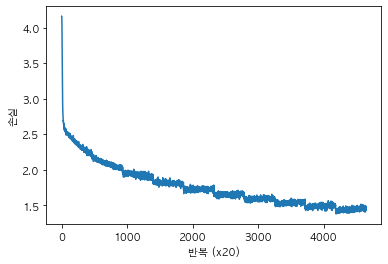

In [3]:
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석 해제(쿠파이 필요)
# ====================================
# config.GPU = True
# ====================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from ch04.cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

### 4.3.3 CBOW 모델 평가

2장에서 구현한 most_similar()메서드를 이용하여, 단어 몇 개에 대해 거리가 가장 가까운 단어들을 뽑아서 평가

In [8]:
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7177734375
 i: 0.69091796875
 your: 0.62890625
 they: 0.576171875
 weird: 0.56787109375

[query] year
 month: 0.86962890625
 week: 0.76318359375
 summer: 0.7568359375
 spring: 0.7216796875
 decade: 0.65380859375

[query] car
 window: 0.6240234375
 truck: 0.6142578125
 luxury: 0.5888671875
 cars: 0.58642578125
 auto: 0.5751953125

[query] toyota
 coated: 0.6474609375
 engines: 0.64697265625
 mazda: 0.63916015625
 f-14: 0.62353515625
 minivans: 0.62060546875


word2vec으로 얻은 단어의 분산 표현은 비슷한 단어를 가까이 모을 뿐 아니라, 더 복잡한 패턴을 파악하는 것으로 알려져 있음  
  
대표적인 예로 "king - man + woman = queen"으로 유명한 유추 문제(비유 문제)가 있음  
word2vec의 단어의 분산표현을 사용하면 유추 문제를 벡터의 덧셈과 뺄셈으로 풀 수 있음  
  
위 문제는 단어 "man"의 분산 표현(단어 벡터)를 "vec('man')"이라고 표현했을 때 다음과 같이 쓸 수 있다.  
"(vec('women') - vec('man') = vec(?) - vec('king')"  
  
문제를 풀기 위한 코드

In [9]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [10]:
analogy('man','king','woman',word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:king = woman:?
 horse: 4.6171875
 artist: 3.814453125
 a.m: 3.744140625
 wife: 3.716796875
 high-definition: 3.6875


In [11]:
analogy('take','took','go',word_to_id, id_to_word, word_vecs, top=5)


[analogy] take:took = go:?
 eurodollars: 5.23046875
 went: 4.28515625
 were: 4.16796875
 came: 4.109375
 goes: 3.880859375


In [12]:
analogy('car','cars','child',word_to_id, id_to_word, word_vecs, top=5)


[analogy] car:cars = child:?
 a.m: 6.68359375
 rape: 5.59375
 children: 5.390625
 incest: 5.0078125
 adults: 4.80078125


In [13]:
analogy('good','better','bad',word_to_id, id_to_word, word_vecs, top=5)


[analogy] good:better = bad:?
 rather: 5.4453125
 more: 5.36328125
 less: 5.28515625
 greater: 3.900390625
 fewer: 3.876953125


word2vec으로 얻은 단어의 분산 표현을 사용하면, 백터의 덧셈과 뺄셈으로 유추 문제를 풀 수 있음
단어의 단순한 의미뿐 아니라 시제 정보, 단수형과 복수형, 비교급이라는 성질 등의 문법적인 패턴도 파악할 수 있음
  
위의 예시는 결과가 썩 좋지는 않지만🙄  
만약 더 큰 말뭉치로 학습하면, 더 정확하고 더 견고한 단어의 분산 표현을 얻을 수 있으며,  
유추 문제의 정답률(정확도)도 크게 향상될 수 있음

## 4.4 word2vec 남은 주제

### 4.4.1 word2vec을 사용한 애플리케이션의 예

전이 학습 : 한 분야에서 배운 지식을 다른 분야에도 적용하는 기법  
자연어 문제를 풀 때 word2vec의 단어 분산 표현은 처음부터 학습하는 일은 거의 없고,  
대신 먼저 큰 말뭉치(위키백과나 구글 뉴스의 텍트트 데이터 등)로 학습을 마친 후,  
그 분산표현을 각각의 작업에 이용함  
  
단어의 분산 표현은 단어를 고정 길이 벡터로 변환해주는 장점이 있음  
문장(단어의 흐름)도 단어의 분산 표현을 이용하여 고정 길이 벡터로 변환할 수 있음  
문장을 고정 길이 벡터로 변환하는 가장 간단한 방법은 문장의 각 단어를 분산 표현으로 변환하고 그 합을 구함!  
이를 bag-of-words라 하여, 단어의 순서를 고려하지 않은 모델임  
순환 신경망(RNN)을 사용하면 조금 더 세련된 방법으로 word2vec의 단어 분산 표현을 이용하면서 문장을 고정 길이 벡터로 변환할 수 있음!  
자연어를 벡터로 변환을 하게되면 일반적인 머신러닝 기법(신경망이나 SVM 등)을 적용할 수 있음  
  
< 참고 >  
  
단어의 분산 표현 학습과 머신러닝 시스템의 학습은 서로 다른 데이터셋을 사용해 개별적으로 수행하는 것이 일반적임  
예컨대 단어의 분산 표현은 위키백과와 같은 범용 말뭉치를 사용해 미리 학습  
그리고 현재 직면한 문제에 관련하여 수집한 데이터를 가지고 머신러닝 시스템(SVM 등)을 학습시킴  

### 4.4.2 단어 벡터 평가 방법

단어의 분산 표현의 우수성은 실제 애플리케이션과는 분리해 평가하는 것이 일반적임  
자주 사용되는 평가 척도는 단어의 '유사성'이나 '유추 문제'를 활용한 평가  
  
- 유사성 평가  
  
사람이 작성한 단어 유사도를 검증세트를 사용해 평가하는 것이 일반적  
사람이 부여한 점수와 word2vec에 의한 코사인 유사도 점수를 비교하여 그 상관성을 평가함  
  
- 유추 문제  
  
"king : queen = man : ?"와 같은 유추 문제를 출제하고,  
그 정답률로 단어의 분산 표현의 우수성을 측정함  
  
----------
  
word2vec 모델 비교  
  
모델|차수|말뭉치 크기|의미(semantics)|구문(syntax)|종합
---|---|--------|--------------|-----------|---
CBOW     |300|16억|16.1|52.6|36.1
skip_gram|300|10억|61|61|61
CBOW     |300|60억|63.6|67.4|65.7
skip_gram|300|60억|73.0|66.0|69.1
CBOW     |1000|60억|57.3|68.9|63.7
skip_gram|1000|60억|66.1|65.1|65.6

Pennington. Jeffrey, Richard Socher, and Christopher D. Manning:
"Glove:Global Vectors for Word Representation." EMNLP. Vol.14.2014  
  
- 의미(semantics) : 단어의 의미를 유추하는 유추 문제의 정답률
- 구문(syntax) : 단어의 형태 정보를 유추하는 유추 문제의 정답률  
  
위 결과로부터 다음 사항을 알 수 있음  
- 일반적으로 말뭉치가 클수록 결과가 좋음
- 단어 벡터 차원 수는 적당한 크기가 좋음  
  
하지만, 유추 문제에 의한 평가가 높다고 해서 애플리케이션에서도 반드시 좋은 결과가 나오리라는 보장은 없음